# Image Segmentation: Oxford Pets

In [1]:
import os
import re
import sys
import PIL
import json
import math
import time
import random
import sklearn
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
import tensorflow.keras.mixed_precision as mixed_precision
from IPython.display import clear_output
K.clear_session()

physical_devices = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

def enable_amp():
    # policy = mixed_precision.Policy("mixed_float16")
    # mixed_precision.set_policy(policy)
    mixed_precision.set_global_policy("mixed_float16")
    
print("Tensorflow version: ", tf.__version__)
print(physical_devices)
enable_amp()

Tensorflow version:  2.4.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2070 SUPER, compute capability 7.5


In [2]:
def read_tfrecord(serialized_example):
    feature_description = {
        'image': tf.io.FixedLenFeature((), tf.string),
        'segmentation': tf.io.FixedLenFeature((), tf.string),
        'height': tf.io.FixedLenFeature((), tf.int64),
        'width': tf.io.FixedLenFeature((), tf.int64),
        'image_depth': tf.io.FixedLenFeature((), tf.int64),
        'mask_depth': tf.io.FixedLenFeature((), tf.int64),
    }
    example = tf.io.parse_single_example(serialized_example, feature_description)
    
    image = tf.io.parse_tensor(example['image'], out_type = float)
    image_shape = [example['height'], example['width'], 3]
    image = tf.reshape(image, image_shape)
    
    mask = tf.io.parse_tensor(example['segmentation'], out_type = tf.uint8)
    mask_shape = [example['height'], example['width'], 1]
    mask = tf.reshape(mask, mask_shape)
    
    return image, mask


def get_dataset_from_tfrecord(tfrecord_dir):
    tfrecord_dataset = tf.data.TFRecordDataset(tfrecord_dir)
    parsed_dataset = tfrecord_dataset.map(read_tfrecord)
    return parsed_dataset

In [3]:
train_tfrecord_dir = 'train.tfrecords'
test_tfrecord_dir = 'test.tfrecords'

img_height = 256
img_width = 256
n_classes = 4

In [4]:
@tf.function
def mask_to_categorical(image, mask):
    mask = tf.squeeze(mask)
    mask = tf.one_hot(tf.cast(mask, tf.int32), n_classes)
    mask = tf.cast(mask, tf.float32)
    return image, mask


@tf.function
def load_image_train(input_image, input_mask):
    input_image = tf.image.resize(input_image, (img_height, img_width))
    input_mask = tf.image.resize(input_mask, (img_height, img_width))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = mask_to_categorical(input_image, input_mask)
    input_mask = tf.squeeze(input_mask)

    return input_image, input_mask

def load_image_test(input_image, input_mask):
    input_image = tf.image.resize(input_image, (img_height, img_width))
    input_mask = tf.image.resize(input_mask, (img_height, img_width))
    
    input_image, input_mask = mask_to_categorical(input_image, input_mask)
    input_mask = tf.squeeze(input_mask)

    return input_image, input_mask

In [5]:
TRAIN_LENGTH = 5912
TEST_LENGTH = 1478
BATCH_SIZE = 8
BUFFER_SIZE = TRAIN_LENGTH 
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [6]:
train_tfrecords_dataset = get_dataset_from_tfrecord(train_tfrecord_dir)
test_tfrecords_dataset = get_dataset_from_tfrecord(test_tfrecord_dir)

In [7]:
# Preprocessing: resize the images and masks, flip them, and normalize them
train = train_tfrecords_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = test_tfrecords_dataset.map(load_image_test)

In [8]:
# the cache() transformation reduces resource usage
train_dataset = train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [9]:
def display(display_list):
    plt.figure(figsize=(15, 5))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

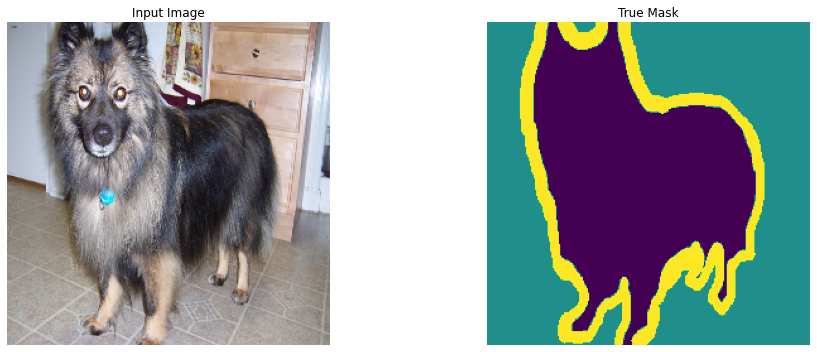

In [10]:
for image, mask in test.take(13):
    sample_image, sample_mask = image, mask
    
sample_mask = tf.argmax(sample_mask, axis=-1)
sample_mask = sample_mask[..., tf.newaxis]
display([sample_image, sample_mask])

### Define the model

In [11]:
def unet_model(input_height=img_height,  input_width=img_width, n_classes = 3):
    
    img_input = tf.keras.layers.Input(shape=(input_height, input_width, 3))

    # -------------------------- Encoder --------------------------
    
    c1 = Conv2D(64, 3, padding='same', activation="relu")(img_input)
    c1 = Conv2D(64, 3, padding='same', activation="relu")(c1)
    p1 = MaxPooling2D((2,2))(c1)
    
    c2 = Conv2D(128, 3, padding='same', activation="relu")(p1)
    c2 = Conv2D(128, 3, padding='same', activation="relu")(c2)
    p2 = MaxPooling2D((2,2))(c2)
    p2 = Dropout(0.1)(p2)
    
    c3 = Conv2D(256, 3, padding='same', activation="relu")(p2)
    c3 = Conv2D(256, 3, padding='same', activation="relu")(c3)
    p3 = MaxPooling2D((2,2))(c3)
    p3 = Dropout(0.2)(p3)
    
    c4 = Conv2D(512, 3, padding='same', activation="relu")(p3)
    c4 = Conv2D(512, 3, padding='same', activation="relu")(c4)
    p4 = MaxPooling2D((2,2))(c4)
    p4 = Dropout(0.3)(p4)
    
    # ------------------------ Bottleneck -------------------------
    
    c5 = Conv2D(768, 3, padding='same', activation="relu")(p4)
    c5 = Conv2D(768, 3, padding='same', activation="relu")(c5)
    c5 = Dropout(0.5)(c5)
    
    # -------------------------- Decoder --------------------------
    # Can also use transpose convolutions instead of upsampling
    
    u6 = concatenate([UpSampling2D(2)(c5), c4])
    c6 = Conv2D(512, 3, padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)
    c6 = Conv2D(256, 3, padding='same')(c6)
    c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)
    c6 = Dropout(0.3)(c6)
    
    u7 = concatenate([UpSampling2D(2)(c6), c3])
    c7 = Conv2D(256, 3, padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)
    c7 = Conv2D(128, 3, padding='same')(c7)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)
    c7 = Dropout(0.2)(c7)

    u8 = concatenate([UpSampling2D(2)(c7), c2])
    c8 = Conv2D(128, 3, padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)
    c8 = Conv2D(64, 3, padding='same')(c8)
    c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)
    c8 = Dropout(0.1)(c8)

    u9 = concatenate([UpSampling2D(2)(c8), c1]) 
    c9 = Conv2D(64, 3, padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Activation('relu')(c9)
    c9 = Conv2D(64, 3, padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Activation('relu')(c9)
    c9 = Conv2D(n_classes, 3, padding='same')(c9)
    
    # Softmax for multi-class prediction
    output = Activation("softmax", dtype='float32')(c9)
    
    return tf.keras.Model(inputs=img_input, outputs=output)


def dice_coef(y_true, y_pred):
    smooth = 1.0
    intersection = K.sum(y_true * y_pred, axis=(1,2))
    mask_sum = K.sum(y_true, axis=(1,2)) + K.sum(y_pred, axis=(1,2))
    union = mask_sum - intersection
    dice = K.mean((2. * intersection + smooth) / (mask_sum + smooth))
    return dice


def cce_dice_loss(y_true, y_pred):
    return (tf.keras.losses.categorical_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)) + 1

In [12]:
model = unet_model(input_height=img_height, input_width=img_width, n_classes=4)

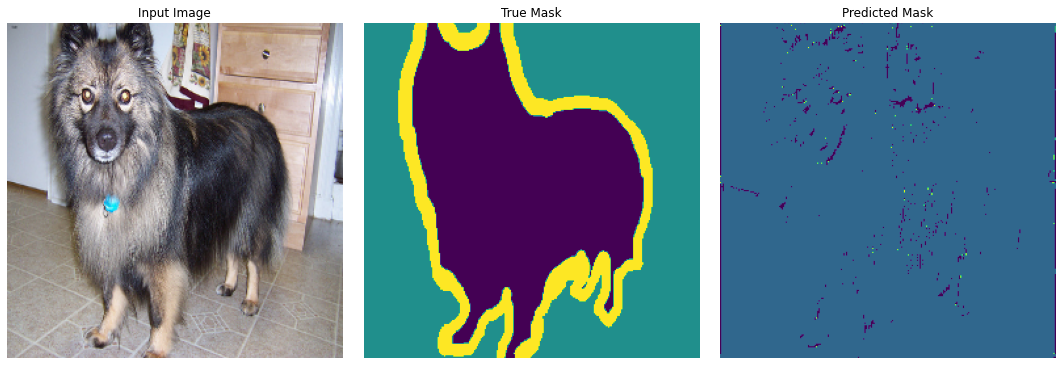

In [13]:
def create_mask(pred_mask):
    pred_mask = tf.squeeze(pred_mask, axis=0)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask


def show_predictions():
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    display([sample_image, sample_mask, create_mask(pred_mask)])

        
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
        
show_predictions()

### Training

In [14]:
model_name = "saved_models\\unet_pets.h5"

model.compile(optimizer = tf.keras.optimizers.Adam(lr=1e-4),
              loss = cce_dice_loss, 
              metrics = ['accuracy', dice_coef])

callbacks = [
    DisplayCallback(),
    EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', patience=3, factor=0.1, min_lr=1e-7, verbose=1),
    ModelCheckpoint(model_name, monitor='val_loss', verbose=1, mode='min', 
                    save_best_only=True, save_weights_only=True)
]
# model.load_weights("big_unet_model.h5", by_name=True)

In [15]:
EPOCHS = 100
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = TEST_LENGTH//BATCH_SIZE

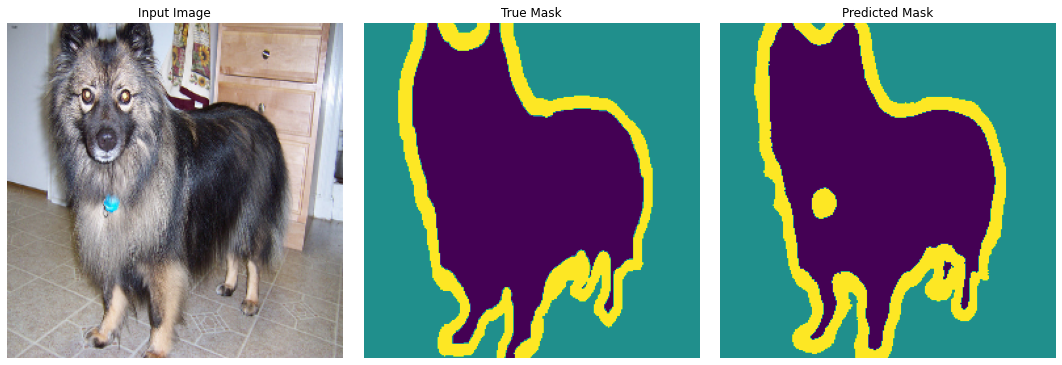


Sample Prediction after epoch 24


Epoch 00024: val_loss did not improve from 0.37995
Epoch 00024: early stopping
#### time: 44.0 min at 111.0 s per epoch


In [16]:
start_time = time.time()
results = model.fit(train_dataset,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_steps=VALIDATION_STEPS,
                    epochs = EPOCHS,
                    validation_data = test_dataset,
                    callbacks = callbacks,
                    verbose = 1)
end_time = time.time()

t_minutes = (end_time - start_time) // 60
t_per_epoch = (end_time - start_time)  // len(results.history["loss"])
print("#### time: {} min at {} s per epoch".format(t_minutes, t_per_epoch))

In [ ]:
# model.load_weights("saved_models\\unet_pets.h5")

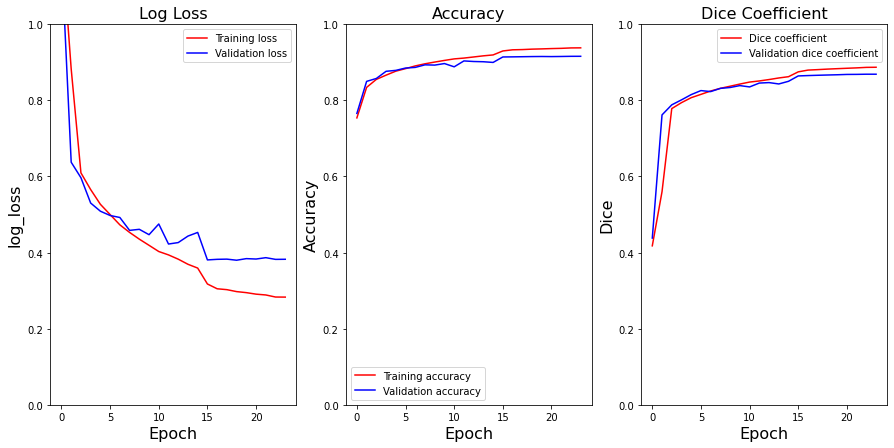

In [17]:
plt.figure(figsize=(15,7))

plt.subplot(1,3,1)  
plt.plot(results.history['loss'], 'r', label='Training loss')
plt.plot(results.history['val_loss'], 'b', label='Validation loss')
plt.title('Log Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('log_loss', fontsize=16)
plt.ylim([0, 1])
plt.legend()

plt.subplot(1,3,2)
plt.plot(results.history['accuracy'], 'r', label='Training accuracy')
plt.plot(results.history['val_accuracy'], 'b', label='Validation accuracy')
plt.title('Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.ylim([0, 1])
plt.legend()

plt.subplot(1,3,3)
plt.plot(results.history['dice_coef'], 'r', label='Dice coefficient')
plt.plot(results.history['val_dice_coef'], 'b', label='Validation dice coefficient')
plt.title('Dice Coefficient', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Dice', fontsize=16)
plt.ylim([0, 1])
plt.legend()
plt.show()